In [1]:
import os
import json

In [2]:
results_filename = 'benchmark_results.json'

with open(results_filename) as f:
    results = json.load(f)

In [9]:
def compute_successes_per_task(results):
    success_counts = {}
    for task_name, task_instances in results.items():
        success_counts[task_name] = {}
        count = sum(1 for instance in task_instances.values() if instance['plan_succeeded'])
        success_counts[task_name]['successes'] = count
        success_counts[task_name]['trials'] = len(task_instances.items())
    return success_counts

In [11]:
compute_successes_per_task(results)

{'setting_up_candles': {'successes': 0, 'trials': 18},
 'sorting_books': {'successes': 17, 'trials': 18},
 'cleaning_out_drawers': {'successes': 11, 'trials': 18},
 'locking_every_door': {'successes': 17, 'trials': 18},
 'locking_every_window': {'successes': 17, 'trials': 18},
 'packing_food_for_work': {'successes': 12, 'trials': 18}}

cleaning_out_drawers: failures are legit, change variants

locking_every_door : first 2 failures failures are legit, change variants


In [12]:
from collections import defaultdict

def compute_action_failure_stats(results):
    action_failures = defaultdict(int)
    action_attempts = defaultdict(int)

    for task_instances in results.values():
        for instance in task_instances.values():
            plan = instance['plan_status']['plan']
            successes = instance['plan_status']['successes']
            for step, success in zip(plan, successes):
                action = step['action']
                action_attempts[action] += 1
                if not success:
                    action_failures[action] += 1
                    break # count first failing action only

    # Optional: return failure rate as well
    action_failure_stats = {
        action: {
            'failures': action_failures[action],
            'attempts': action_attempts[action],
            'failure_rate': action_failures[action] / action_attempts[action]
        }
        for action in action_attempts
    }

    return action_failure_stats


In [20]:
results_no_candles = {key:results[key] for key in results if 'candles' not in key}
compute_action_failure_stats(results_no_candles)

{'navigate-to': {'failures': 5,
  'attempts': 183,
  'failure_rate': 0.0273224043715847},
 'grasp': {'failures': 1,
  'attempts': 43,
  'failure_rate': 0.023255813953488372},
 'place-on': {'failures': 0, 'attempts': 28, 'failure_rate': 0.0},
 'open-container': {'failures': 6, 'attempts': 32, 'failure_rate': 0.1875},
 'close-container': {'failures': 2,
  'attempts': 87,
  'failure_rate': 0.022988505747126436},
 'place-inside': {'failures': 2,
  'attempts': 14,
  'failure_rate': 0.14285714285714285}}

In [14]:
results

{'setting_up_candles': {'0': {'scene_id': 'Beechwood_0_int',
   'instance_id': 0,
   'plan_succeeded': False,
   'plan_status': {'plan': [{'action': 'navigate-to', 'params': ['carton_1']},
     {'action': 'open-container', 'params': ['carton_1']},
     {'action': 'grasp', 'params': ['candle_1']},
     {'action': 'navigate-to', 'params': ['table_1']},
     {'action': 'place-on', 'params': ['candle_1', 'table_1']}],
    'successes': [True, False, True, True, True],
    'legals': [True, True, True, True, True]}},
  '1': {'scene_id': 'Beechwood_0_int',
   'instance_id': 20,
   'plan_succeeded': False,
   'plan_status': {'plan': [{'action': 'navigate-to', 'params': ['carton_1']},
     {'action': 'open-container', 'params': ['carton_1']},
     {'action': 'grasp', 'params': ['candle_1']},
     {'action': 'navigate-to', 'params': ['table_1']},
     {'action': 'place-on', 'params': ['candle_1', 'table_1']}],
    'successes': [True, False, True, True, True],
    'legals': [True, True, True, True

In [15]:
def get_successful_configs(results):
    successful_configs = {}
    for task in results.keys():
        successful_task_configs = [{'scene_id':x['scene_id'], 'instance_id':x['instance_id']} for x in results[task].values() if x['plan_succeeded']]
        if len(successful_task_configs) > 0:
            successful_configs[task] = successful_task_configs

    return successful_configs      

In [17]:
successful_configs = get_successful_configs(results)

successful_configs_filename = 'successful_configs.json'

with open(successful_configs_filename, 'w') as f:
    json.dump(successful_configs, f, indent=4)

# Inspect failed plans

In [8]:
import os
import json
import numpy as np
from PIL import Image

from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader
up.shortcuts.get_env().credits_stream = None # Disable print of credits

import bddl
from igibson.action_primitives.fetch_robot_semantic_actions_env import FetchRobotSemanticActionEnv
from igibson.custom_utils import get_env_config, print_properties
import igibson.render_utils as render_utils

from planning_utils import print_symbolic_state, execute_plan, translate_str_to_dict

import warnings
warnings.filterwarnings("ignore")


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



/miniconda/envs/igibson/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def get_list_failed_plans(results):
    failed_plans = {}

    for task_name, task_instances in results.items():
        failed_plans[task_name] = []
        for instance in task_instances.values():
            if not instance['plan_succeeded']:
                scene_id = instance['scene_id']
                instance_id = instance['instance_id']
                plan = instance['plan_status']['plan']
                successes = instance['plan_status']['successes']
                
                # Find the first failed action
                first_failed_action = None
                for step, success in zip(plan, successes):
                    if not success:
                        first_failed_action = step['action']
                        break

                failed_plans[task_name].append((scene_id, instance_id, first_failed_action))

    return failed_plans

get_list_failed_plans(results)

{'cleaning_out_drawers': [('Pomaria_1_int', 0, 'open-container'),
  ('Pomaria_1_int', 20, 'open-container')],
 'locking_every_door': [('Merom_1_int', 0, 'close-container'),
  ('Merom_1_int', 20, 'close-container'),
  ('Wainscott_1_int', 0, 'navigate-to')],
 'locking_every_window': [('Rs_int', 20, 'close-container')],
 'packing_food_for_work': [('Ihlen_1_int', 0, 'navigate-to')]}

In [16]:
# Unsolved
task = 'packing_food_for_work'
scene_id = 'Ihlen_1_int'
instance_id = 0

# First and second windows didn't close
plan = [{'action': 'navigate-to', 'params': ['cabinet_1']},
     {'action': 'open-container', 'params': ['cabinet_1']},
     {'action': 'grasp', 'params': ['snack_food_1']},
     {'action': 'navigate-to', 'params': ['carton_1']},
     {'action': 'place-inside', 'params': ['snack_food_1', 'carton_1']}]

Rendering settings is None - going with the default settings!


scene quality check: toilet_47 has joint that cannot extend for >66%.


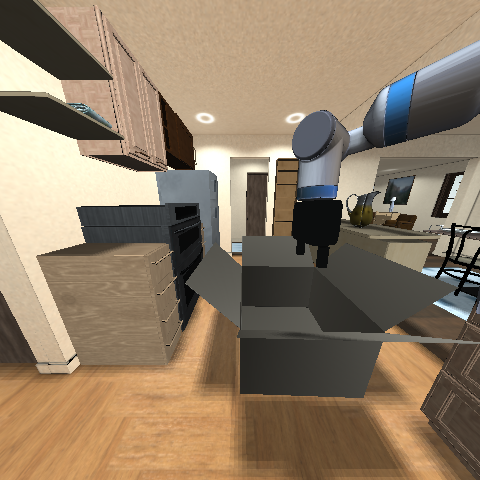

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object not visible.
Object

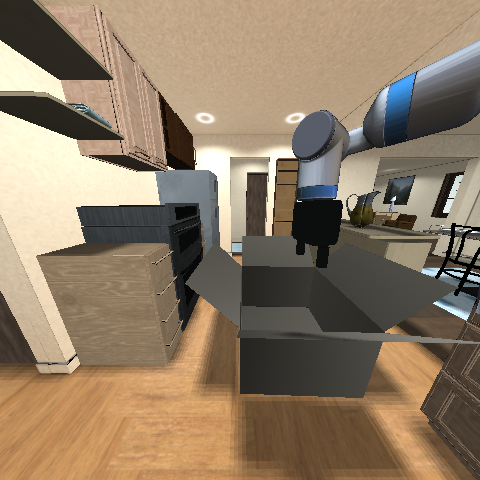

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
distance_from_container:  2.429867038381282
is_near:  False
_is_near:  False
total_visible_pixels:  1628
bbox_vertices_uv:  [[176.83119428 136.27386369]
 [180.33453508 170.29361491]
 [199.47535585 136.2739904 ]
 [201.72284779 170.29367295]
 [132.79445259  90.22325359]
 [142.50942385 149.98367391]
 [171.22502117  90.22361856]
 [177.45739422 149.98382888]]
projected_bbox_pixels:  3855.

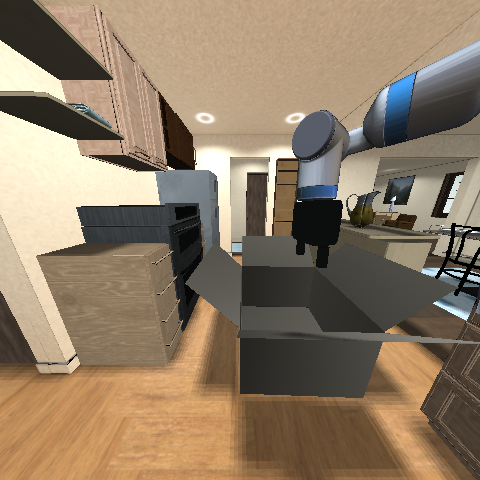

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Preconditions not satisfied. reachable(snack_food.n.01_1)=False ; empty_hand()=True
Action {'action': 'grasp', 'params': ['snack_food_1']} executed. Success: False


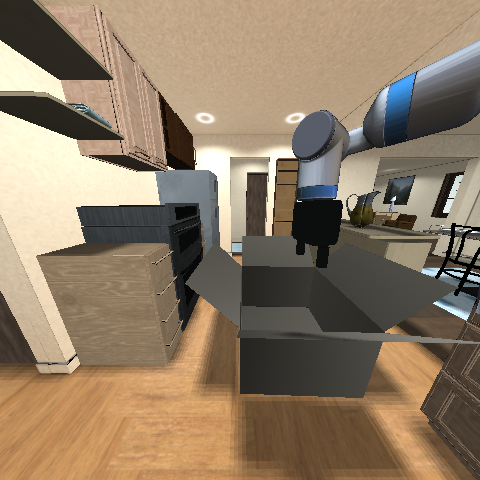

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Start collision test.
torso_lift_link has collision with objects [150]
elbow_flex_link has collision with objects [150]
wrist_flex_link has collision with objects [150]
gripper_link has collision with objects [150]
End collision test.
Candidate position failed collision test.
Start collision test.
torso_lift_link has collision with objects [150]
elbow_flex_link has collision with obj

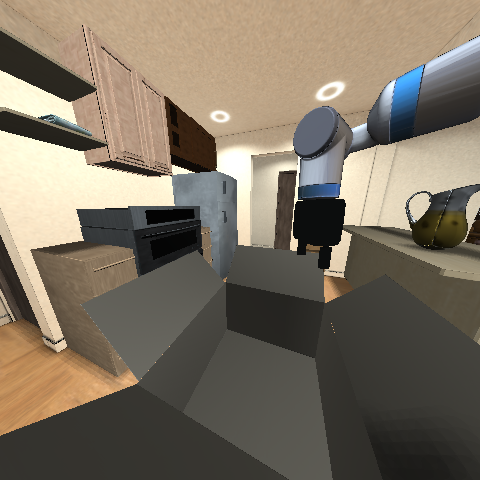

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'countertop.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Preconditions not satisfied. reachable=True ; is_open=True ; holding_trg_obj=False
Action {'action': 'place-inside', 'params': ['snack_food_1', 'carton_1']} executed. Success: False


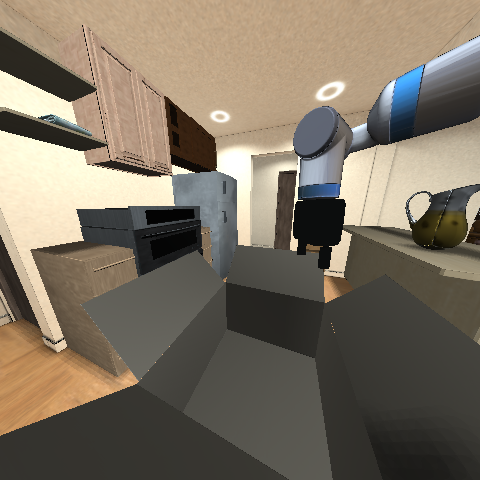

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'countertop.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------


In [17]:
# Init env
sim_env = FetchRobotSemanticActionEnv(task, scene_id, instance_id, verbose=True, debug=True)

# Here goes the planning logic / benchmarking part
plan_succeeded, plan_status = execute_plan(sim_env, plan, task, task_instance=0)

# Shut down gracefully to avoid memory leaks
sim_env.env.clean()

### Env inspected

In [10]:
# Solved

task = 'cleaning_out_drawers'
scene_id = 'Benevolence_1_int'
instance_id = 0

plan = [
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #1
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #2
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #3
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #4
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #5
    {'action':'close-container', 'params':['cabinet_1']},
       ]

In [12]:
task = 'cleaning_out_drawers'
scene_id = 'Pomaria_1_int'
instance_id = 0

# Solved
#plan = [
#    {'action':'navigate-to', 'params':['cabinet_1']} for _ in range(10)
#]

# Unsolved, cabinet doesn't open, change env
plan = [
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #1
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #2
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #3
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #4
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #5
    {'action':'close-container', 'params':['cabinet_1']},
       ]

In [14]:
# Unsolved, change env

task = 'cleaning_out_drawers'
scene_id = 'Pomaria_1_int'
instance_id = 20

plan = [
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #1
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #2
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #3
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #4
    {'action':'close-container', 'params':['cabinet_1']},
    {'action':'navigate-to', 'params':['cabinet_1']},
    {'action':'open-container', 'params':['cabinet_1']}, #5
    {'action':'close-container', 'params':['cabinet_1']},
       ]

In [19]:
# Unsolved, door doesn't close
task = 'locking_every_door'
scene_id = 'Merom_1_int'
instance_id = 0

plan = [
    {'action':'navigate-to', 'params':['door_1']},
    {'action':'close-container', 'params':['door_1']},
    {'action':'navigate-to', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
]

In [10]:
# Unsolved, door doesn't close
task = 'locking_every_door'
scene_id = 'Merom_1_int'
instance_id = 20

plan = [
    {'action':'navigate-to', 'params':['door_1']},
    {'action':'close-container', 'params':['door_1']},
    {'action':'navigate-to', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
]

In [12]:
# Solved
task = 'locking_every_door'
scene_id = 'Wainscott_1_int'
instance_id = 0


plan = [
    {'action':'navigate-to', 'params':['door_1']},
    {'action':'close-container', 'params':['door_1']},
    {'action':'navigate-to', 'params':['door_2']},
    {'action':'close-container', 'params':['door_2']},
]

In [14]:
# Unsolved
task = 'locking_every_window'
scene_id = 'Rs_int'
instance_id = 20

# First and second windows didn't close
plan =[{'action': 'navigate-to', 'params': ['window_1']},
     {'action': 'close-container', 'params': ['window_1']},
     {'action': 'navigate-to', 'params': ['window_2']},
     {'action': 'close-container', 'params': ['window_2']},
     {'action': 'navigate-to', 'params': ['window_3']},
     {'action': 'close-container', 'params': ['window_3']}]